In [1]:
import torch
import numpy as np;
from torch.autograd import Variable


def normal_std(x):
    return x.std() * np.sqrt((len(x) - 1.)/(len(x)))

class Data_utility(object):
    # train and valid is the ratio of training set and validation set. test = 1 - train - valid
    def __init__(self, file_name, train, valid, cuda, horizon, window, normalize = 2):
        self.cuda = cuda;
        self.P = window;
        self.h = horizon
        fin = open(file_name);
        self.rawdat = np.loadtxt(fin,delimiter=',')
        if(len(self.rawdat.shape)) == 1:
            self.rawdat = self.rawdat.reshape(len(self.rawdat), -1)
        self.dat = np.zeros(self.rawdat.shape)        
        self.n, self.m = self.dat.shape;
        self.normalize = 2
        self.scale = np.ones(self.m);
        self._normalized(normalize);
        self._split(int(train * self.n), int((train+valid) * self.n), self.n);
        
        self.scale = torch.from_numpy(self.scale).float();
        tmp = self.test[1] * self.scale.expand(self.test[1].size(0), self.m);
            
        if self.cuda:
            self.scale = self.scale.cuda();
        self.scale = Variable(self.scale);
        
        self.rse = normal_std(tmp);
        self.rae = torch.mean(torch.abs(tmp - torch.mean(tmp)));
    
    def _normalized(self, normalize):
       
        if (normalize == 0):
            self.dat = self.rawdat
        
        # normalized by the maximum value of entire matrix.
        if (normalize == 1):
            self.dat = self.rawdat / np.max(self.rawdat);
            
        # normlized by the maximum value of each column(sensor).
        if (normalize == 2):
            for i in range(self.m):
                self.scale[i] = np.max(np.abs(self.rawdat[:,i]));
                self.dat[:,i] = self.rawdat[:,i] / np.max(np.abs(self.rawdat[:,i]));
            
        
    def _split(self, train, valid, test):
        
        train_set = range(self.P+self.h-1, train);
        valid_set = range(train, valid);
        test_set = range(valid, self.n);
        self.train = self._batchify(train_set, self.h);
        self.valid = self._batchify(valid_set, self.h);
        self.test = self._batchify(test_set, self.h);
        
        
    def _batchify(self, idx_set, horizon):
        
        n = len(idx_set);
        X = torch.zeros((n,self.P,self.m));
        Y = torch.zeros((n,self.m));
        
        for i in range(n):
            end = idx_set[i] - self.h + 1;
            start = end - self.P;
            X[i,:,:] = torch.from_numpy(self.dat[start:end, :]);
            Y[i,:] = torch.from_numpy(self.dat[idx_set[i], :]);

        return [X, Y];

    def get_batches(self, inputs, targets, batch_size, shuffle=True):
        length = len(inputs)
        if shuffle:
            index = torch.randperm(length)
        else:
            index = torch.LongTensor(range(length))
        start_idx = 0
        while (start_idx < length):
            end_idx = min(length, start_idx + batch_size)
            excerpt = index[start_idx:end_idx]
            X, Y= inputs[excerpt], targets[excerpt]
            if (self.cuda):
                X, Y = X.cuda(), Y.cuda()
            yield Variable(X), Variable(Y)
            start_idx += batch_size

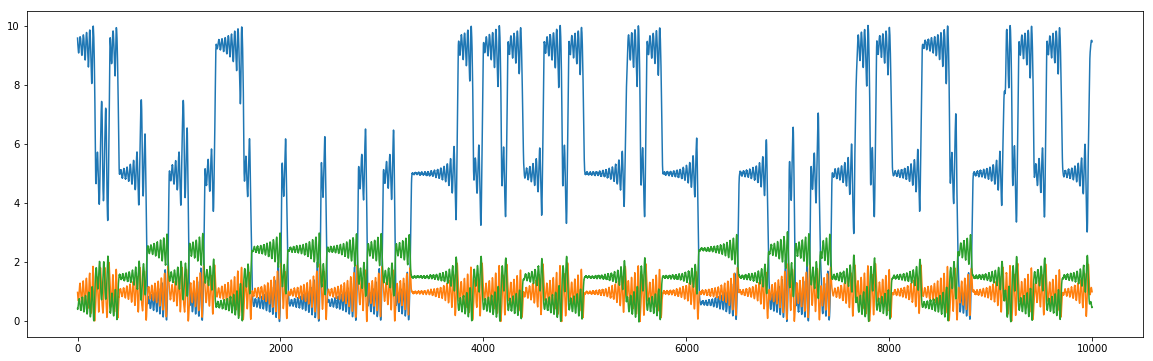

In [240]:
import pandas as pd

df = pd.read_csv('chua.txt', header=None)
df = df * np.array([10,2,3])
df += np.random.randn(*df.shape)*0.01

plt.figure(figsize=(20,6))
_ = plt.plot(df)

df.to_csv('chua_noise.txt', header=None, index=None)

In [241]:
data = Data_utility(file_name='chua_noise.txt', train=0.6, valid=0.2, cuda=False, horizon=30, window=30, normalize = 2)

In [242]:
print(data.train[0].shape, data.train[1].shape)
print(data.scale)

window = data.train[0].shape[1]
n_val = data.train[0].shape[2]

torch.Size([5941, 30, 3]) torch.Size([5941, 3])
tensor([10.0067,  1.9922,  3.0287])


In [243]:
import math
import torch.optim as optim

class Optim(object):

    def _makeOptimizer(self):
        if self.method == 'sgd':
            self.optimizer = optim.SGD(self.params, lr=self.lr)
        elif self.method == 'adagrad':
            self.optimizer = optim.Adagrad(self.params, lr=self.lr)
        elif self.method == 'adadelta':
            self.optimizer = optim.Adadelta(self.params, lr=self.lr)
        elif self.method == 'adam':
            self.optimizer = optim.Adam(self.params, lr=self.lr)
        else:
            raise RuntimeError("Invalid optim method: " + self.method)

    def __init__(self, params, method, lr, max_grad_norm, lr_decay=1, start_decay_at=None):
        self.params = list(params)  # careful: params may be a generator
        self.last_ppl = None
        self.lr = lr
        self.max_grad_norm = max_grad_norm
        self.method = method
        self.lr_decay = lr_decay
        self.start_decay_at = start_decay_at
        self.start_decay = False

        self._makeOptimizer()

    def step(self):
        # Compute gradients norm.
        grad_norm = 0
        for param in self.params:
            grad_norm += math.pow(param.grad.data.norm(), 2)

        grad_norm = math.sqrt(grad_norm)
        if grad_norm > 0:
            shrinkage = self.max_grad_norm / grad_norm
        else:
            shrinkage = 1.

        for param in self.params:
            if shrinkage < 1:
                param.grad.data.mul_(shrinkage)

        self.optimizer.step()
        return grad_norm

    # decay learning rate if validation performance does not improve or we hit the start_decay_at limit
    def updateLearningRate(self, ppl, epoch):
        if self.start_decay_at is None or epoch <= self.start_decay_at:
            return
        if self.last_ppl is not None and ppl > self.last_ppl:
            self.start_decay = True

        if self.start_decay:
            self.lr = self.lr * self.lr_decay
#             print("Decaying learning rate to %g" % self.lr)
        #only decay for one epoch
        self.start_decay = False

        self.last_ppl = ppl

        self._makeOptimizer()

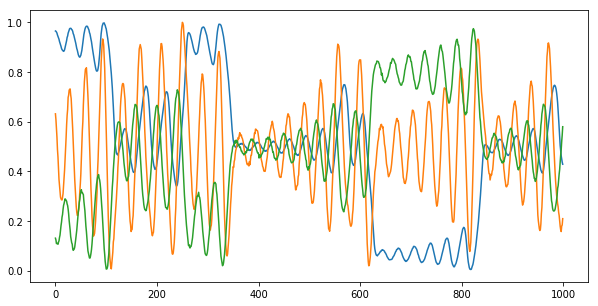

In [244]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(10,5))
plt.plot(data.train[1].numpy()[:1000])
plt.show()

In [245]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Model(nn.Module):
    def __init__(self, n_val, window, hidRNN, quantiles = [0.5]):
        super(Model, self).__init__()
        self.use_cuda = True
        self.P = window  # 输入窗口大小
        self.m = n_val  # 列数，变量数
        self.hidR = hidRNN
        self.quantiles = torch.tensor(quantiles)
        
        self.GRU = nn.GRU(self.m, self.hidR)
       
        self.linear = nn.Linear(self.hidR, self.m * len(quantiles))

 
    def forward(self, x):

        x1 = x.permute(1, 0, 2).contiguous()  # x1: [window, batch, n_val]
        _, h = self.GRU(x1)  # h: [1, batch, hidRNN]
        h = torch.squeeze(h,0)  # h: [batch, hidRNN]
        res =  self.linear(h)  # res: [batch, n_val * n_quantile]
        res = res.view(-1, len(self.quantiles), self.m)
        return res
    

    def MQLoss(self, pred, true):

        quantiles = self.quantiles.unsqueeze(1).expand(len(self.quantiles), self.m)

        true = true.view(-1, 1, self.m).expand(pred.shape)

        tau = torch.gt(pred, true).type(torch.FloatTensor) - quantiles
        loss = tau.mul(pred - true).sum()

        return loss
        


In [246]:
def train(data, X, Y, model, optim, batch_size):
    model.train()
    total_loss = 0
    n_samples = 0
    for X, Y in data.get_batches(X, Y, batch_size, True):
        model.zero_grad();
        output = model(X);
        scale = data.scale.expand(output.size(0), data.m)
#         print(scale.shape, output.shape, Y.shape)
        loss = model.MQLoss(output * scale.unsqueeze(1).expand(output.shape), Y * scale);
        loss.backward();
        grad_norm = optim.step();
        total_loss += loss.item();
        n_samples += (output.size(0) * data.m);
    return total_loss / n_samples

def evaluate(data, X, Y, model, batch_size):
    model.eval()
    total_loss = 0

    n_samples = 0
    predict = None
    test = None
    
    for X, Y in data.get_batches(X, Y, batch_size, False):
        output = model(X)
        if predict is None:
            predict = output
            test = Y
        else:
            predict = torch.cat((predict,output))
            test = torch.cat((test, Y))
        
        scale = data.scale.expand(output.size(0), data.m)
        total_loss += model.MQLoss(output * scale.unsqueeze(1).expand(output.shape), Y * scale).item()

        n_samples += (output.size(0) * data.m)
    
    rse = math.sqrt(total_loss / n_samples)/data.rse
    
    predict = predict.data.cpu().numpy();
    Ytest = test.data.cpu().numpy();

    return rse, predict


model = Model(n_val, window, 32, quantiles=[0.05, 0.5, 0.95]);

nParams = sum([p.nelement() for p in model.parameters()])
print('* number of parameters: %d' % nParams)


 

optimizer = Optim(
    model.parameters(), 'adam', lr=0.01, max_grad_norm=10, start_decay_at = 10, lr_decay = 0.9
)

batch_size=128
epochs = 100
best_val = 10000000
save = 'model.pt'

print('begin training')
import time
for epoch in range(1, epochs):
    epoch_start_time = time.time()
    train_loss = train(data, data.train[0], data.train[1], model, optimizer, batch_size)
    val_loss,  _ = evaluate(data, data.valid[0], data.valid[1], model, batch_size);
    print('| end of epoch {:3d} | time: {:5.2f}s | train_loss {:5.4f} | valid rse {:5.4f} | lr {:5.4f}'
          .format(epoch, (time.time() - epoch_start_time), train_loss, val_loss,  optimizer.lr))
    # Save the model if the validation loss is the best we've seen so far.
    if val_loss < best_val:
        with open(save, 'wb') as f:
            torch.save(model, f)
        best_val = val_loss

    if epoch % 5 == 0:
        test_acc, _  = evaluate(data, data.test[0], data.test[1], model, batch_size);
        print ("test rse {:5.4f}".format(test_acc, test_rae, test_corr))
    
    optimizer.updateLearningRate(val_loss, epoch)


* number of parameters: 3849
begin training
| end of epoch   1 | time:  2.17s | train_loss 0.7679 | valid rse 0.2424 | lr 0.0100
| end of epoch   2 | time:  2.24s | train_loss 0.4384 | valid rse 0.2317 | lr 0.0100
| end of epoch   3 | time:  2.56s | train_loss 0.4215 | valid rse 0.2281 | lr 0.0100
| end of epoch   4 | time:  2.33s | train_loss 0.4009 | valid rse 0.2169 | lr 0.0100
| end of epoch   5 | time:  2.54s | train_loss 0.3735 | valid rse 0.2053 | lr 0.0100
test rse 0.2107
| end of epoch   6 | time:  2.42s | train_loss 0.3399 | valid rse 0.1990 | lr 0.0100
| end of epoch   7 | time:  2.45s | train_loss 0.3097 | valid rse 0.1951 | lr 0.0100
| end of epoch   8 | time:  2.45s | train_loss 0.2897 | valid rse 0.1936 | lr 0.0100
| end of epoch   9 | time:  2.85s | train_loss 0.2636 | valid rse 0.1788 | lr 0.0100
| end of epoch  10 | time:  2.89s | train_loss 0.2576 | valid rse 0.1846 | lr 0.0100
test rse 0.1857
| end of epoch  11 | time:  2.89s | train_loss 0.2212 | valid rse 0.1847 |

| end of epoch  94 | time:  5.30s | train_loss 0.0380 | valid rse 0.1102 | lr 0.0001
| end of epoch  95 | time:  3.28s | train_loss 0.0378 | valid rse 0.1149 | lr 0.0001
test rse 0.1177
| end of epoch  96 | time:  2.93s | train_loss 0.0377 | valid rse 0.1128 | lr 0.0001
| end of epoch  97 | time:  3.23s | train_loss 0.0376 | valid rse 0.1137 | lr 0.0001
| end of epoch  98 | time:  3.12s | train_loss 0.0375 | valid rse 0.1116 | lr 0.0001
| end of epoch  99 | time:  3.19s | train_loss 0.0376 | valid rse 0.1127 | lr 0.0001


In [247]:
test_acc, pred  = evaluate(data, data.test[0], data.test[1], model, batch_size);
print ("test rse {:5.4f} ".format(test_acc))
pred.shape

test rse 0.1161 


(2000, 3, 3)

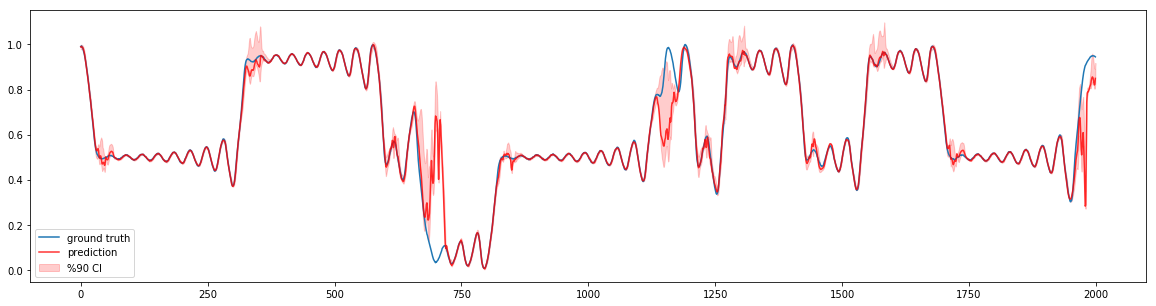

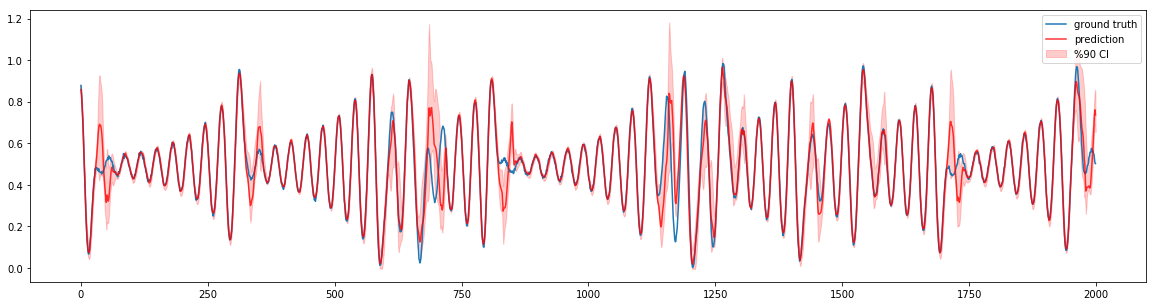

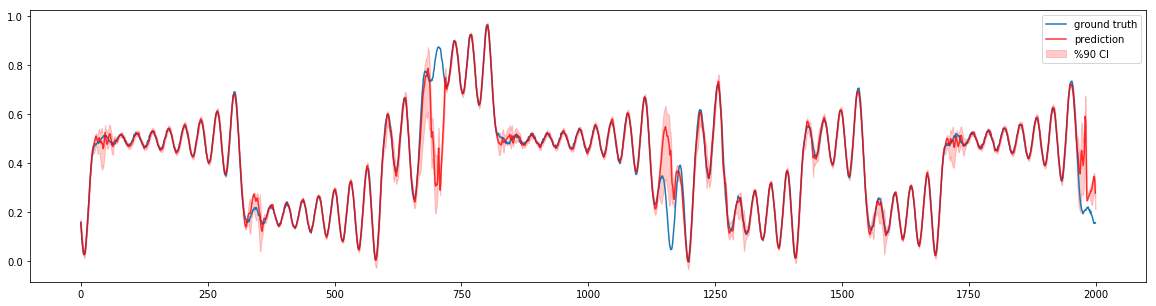

In [255]:
truth = data.test[1].numpy()
length = 2000
for i in range(truth.shape[1]):
    plt.figure(figsize=(20,5))
    plt.plot(truth[:length,i], label='ground truth')
    plt.plot(pred[:length,1,i], label='prediction', color='red', alpha=0.8)
    q1 = pred[:length,0,i]
    q9 = pred[:length,2,i]
    plt.fill_between(range(q1.shape[0]), q1,q9, label='%90 CI', color='red',alpha=0.2)
    plt.legend()
    plt.show()

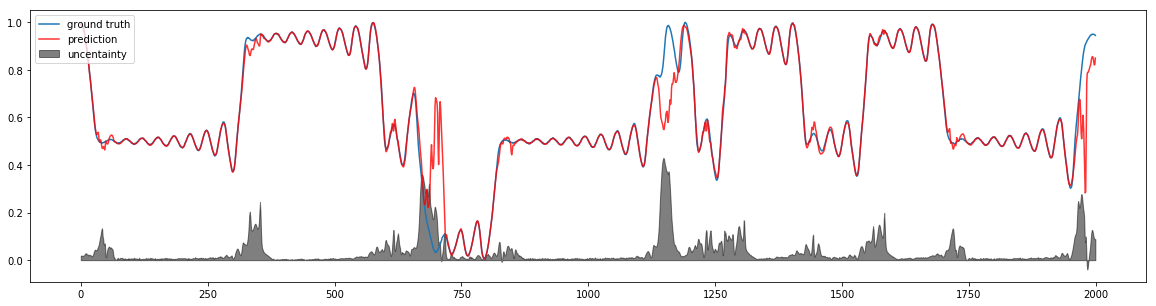

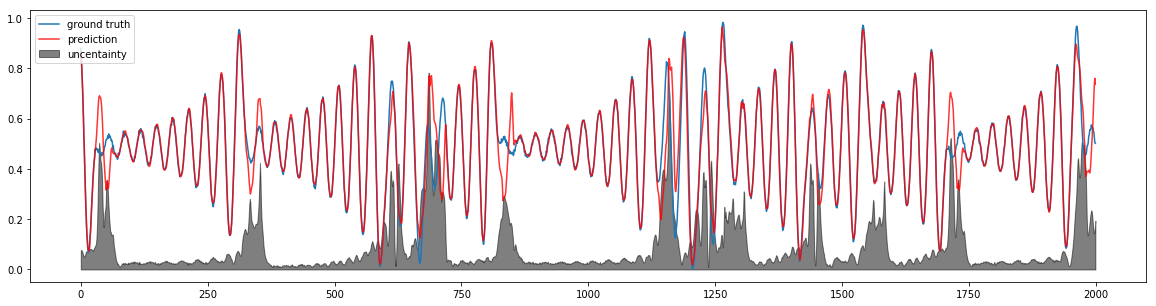

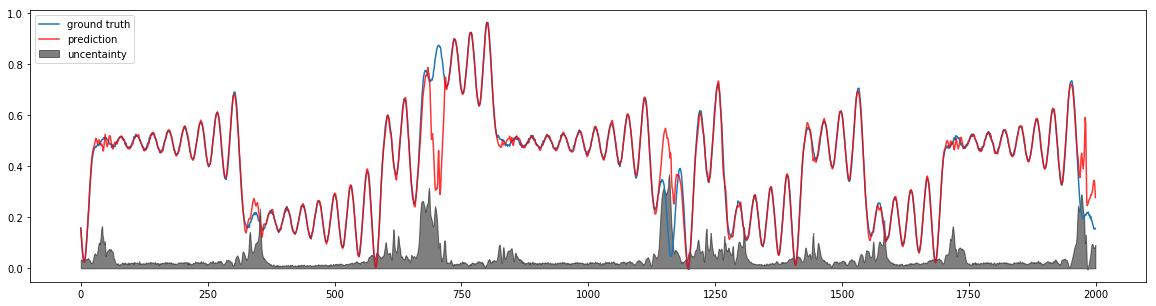

In [256]:
for i in range(truth.shape[1]):
    plt.figure(figsize=(20,5))
    plt.plot(truth[:length,i], label='ground truth')
    plt.plot(pred[:length,1,i], label='prediction', color='red', alpha=0.8)
    q1 = pred[:length,0,i]
    q9 = pred[:length,2,i]
    plt.fill_between(range(length),q9-q1, label='uncentainty', color='black',alpha=0.5)
    plt.legend(loc='upper left')
    plt.show()

In [257]:
train_acc, pred  = evaluate(data, data.train[0], data.train[1], model, batch_size);
print ("test rse {:5.4f} ".format(train_acc))
pred.shape

test rse 0.0681 


(5941, 3, 3)

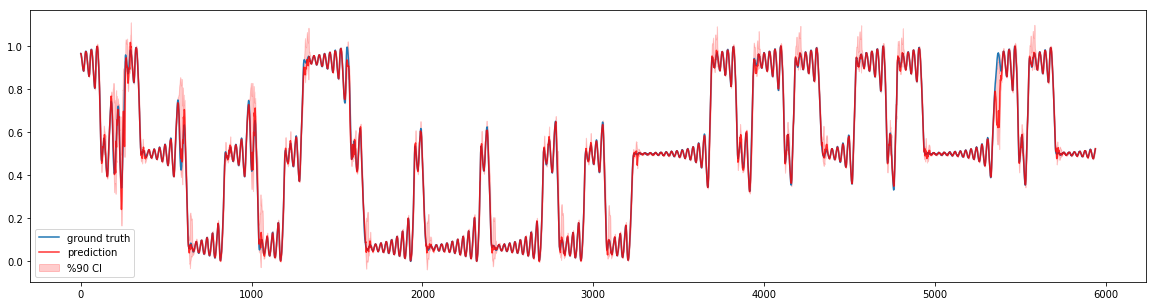

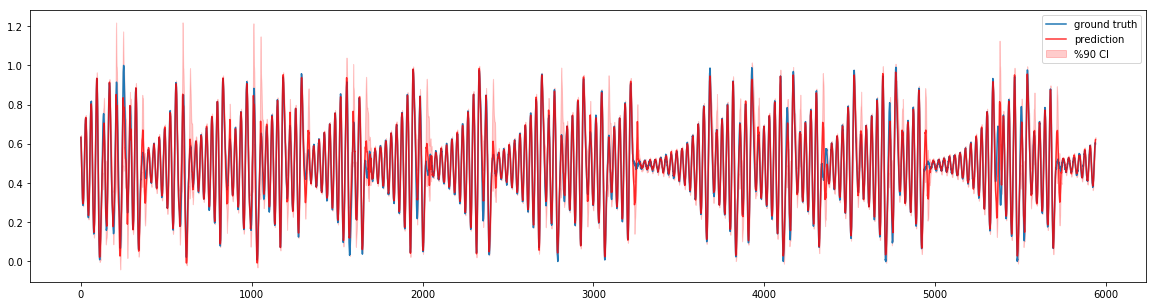

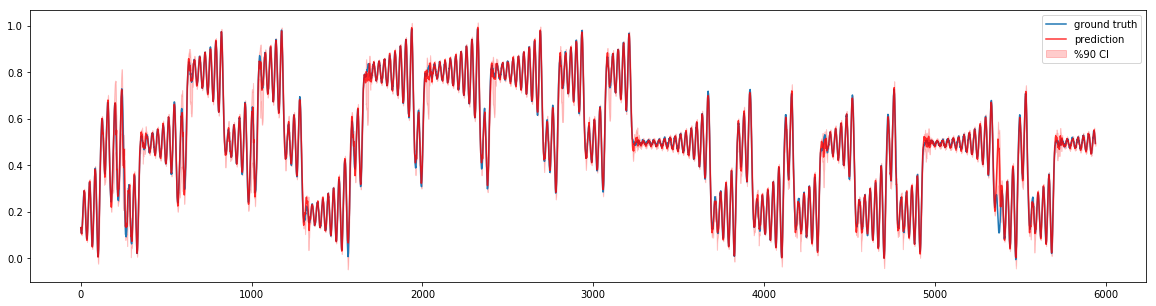

In [259]:
truth = data.train[1].numpy()
length = 6000
for i in range(truth.shape[1]):
    plt.figure(figsize=(20,5))
    plt.plot(truth[:length,i], label='ground truth')
    plt.plot(pred[:length,1,i], label='prediction', color='red', alpha=0.8)
    q1 = pred[:length,0,i]
    q9 = pred[:length,2,i]
    plt.fill_between(range(q1.shape[0]), q1,q9, label='%90 CI', color='red',alpha=0.2)
    plt.legend()
    plt.show()

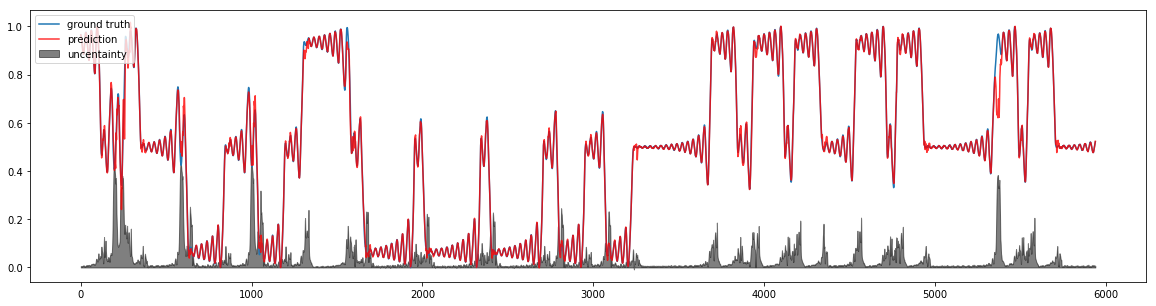

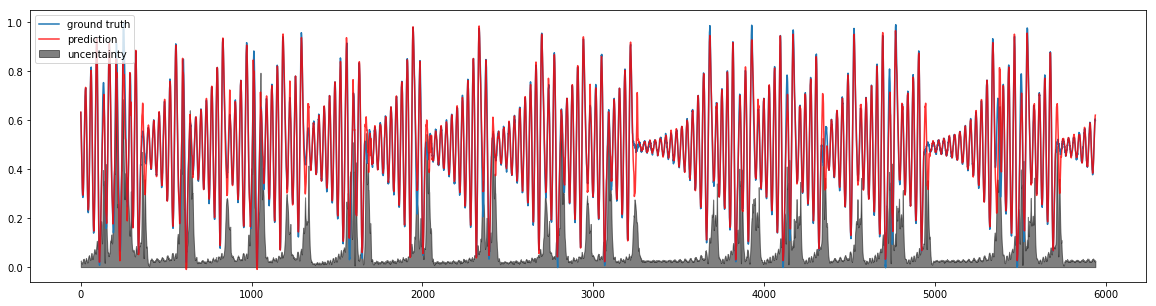

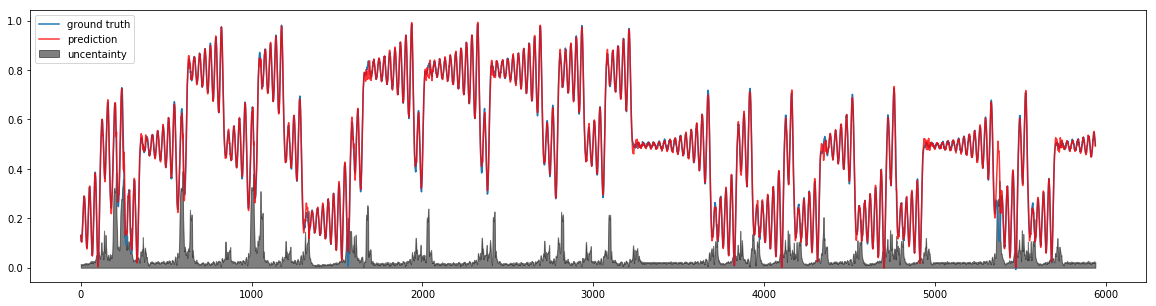

In [261]:
for i in range(truth.shape[1]):
    plt.figure(figsize=(20,5))
    plt.plot(truth[:length,i], label='ground truth')
    plt.plot(pred[:length,1,i], label='prediction', color='red', alpha=0.8)
    q1 = pred[:length,0,i]
    q9 = pred[:length,2,i]
    plt.fill_between(range(len(pred)),q9-q1, label='uncentainty', color='black',alpha=0.5)
    plt.legend(loc='upper left')
    plt.show()